# AlexNet on CIFAR10 
The goal of this notebook is to reimplement [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)  on a 32x32 pixel dataset called CIFAR10. AlexNet is a Convolutional Neural Network Architecture developed by Alex Krizhevsky, and published with Ilya Sutskever and Krizhevsky's doctoral advisor Geoffrey Hinton. It won the [ImagNet large scale Visual Recognition Challange](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge) in September 2012.


In [0]:

import numpy as np 
import pandas as pd
import os


In [0]:
import torch.nn as nn
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
import time

### Transformations
* I resize the images to 256 since AlexNet expects inputs of that size.
* Perform Horizontal flips 50% of the time. This allows the model to recognize objects when they are facing the other direction too.
* Make the images Tensors
* Normalize the images. Now the stats I have below are the mean and standard deviations across all channels. I'll show below how I got them.


In [0]:
transform= transforms.Compose(
    [   transforms.Resize(256),
     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223 , 0.24348513, 0.26158784])
    ])

### Train and Test set

In [4]:
trainset= torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform,
                                      download=True)
testset= torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform,
                                     download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
trainset.data.shape

(50000, 32, 32, 3)

Below I get the mean and standard deviations of the pictures for each channel. These are the stats we use to normalize the images.

In [6]:
train_means= trainset.data.mean(axis=(0,1,2))/255
train_means

array([0.49139968, 0.48215841, 0.44653091])

In [7]:
train_stds= trainset.data.std(axis=(0,1,2))/255
train_stds

array([0.24703223, 0.24348513, 0.26158784])

### Dataloaders

In [0]:
trainloader= torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True,
                                        num_workers=8)
testloader= torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False,
                                       num_workers=8)

In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Get a validation set from the training

In [0]:
from torch.utils.data import Subset
def train_valid_split(dl, val_split=0.25):
    total_items= dl.dataset.data.shape[0]
    idxs= np.random.permutation(total_items)
    train_idxs, valid_idxs= idxs[round(total_items*val_split):], idxs[:round(total_items*val_split)]
    
    train= Subset(dl, train_idxs)
    valid= Subset(dl, valid_idxs)
    return train, valid

In [0]:
train_dl, valid_dl= train_valid_split(trainloader)

## Show images

In [0]:
import matplotlib.pyplot as plt
def show_image(img):
    img= img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


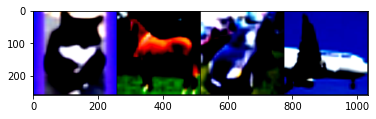

In [13]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
show_image(torchvision.utils.make_grid(images[:4]))

In [14]:
[classes[each] for each in labels[:4]]

['cat', 'horse', 'car', 'plane']

## Model
The model I use is [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). It is the model which basically revolutionalized the space of Deep Learning and brought a lot of attention to this space of Image Classification.

<img src='alex.png'>

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# trainloader.to(device);
print(device)

cuda:0


In [0]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        #1
        self.features= nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        #2
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        #3
        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        #4
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        #5
        nn.Conv2d(384, 256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool= nn.AvgPool2d(6)
        self.classifier= nn.Sequential(
            nn.Dropout(), nn.Linear(256*6*6, 4096),
        nn.ReLU(inplace=True), nn.Dropout(),
        nn.Linear(4096, num_classes))
        
    def forward(self, x):
        x= self.features(x)
        x=x.view(x.size(0), 256*6*6)
        x= self.classifier(x)
        return x

Put the model on the GPU

In [0]:
model= AlexNet(num_classes=10).to(device)

In [18]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AvgPool2d(kernel_size=6, stride=6, padding=0)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): 

In [0]:
#loss function and optimizer
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model.parameters(), lr=3e-4)

I create a function to convert seconds into a human friendly format of hours-minutes-seconds. This I will use to keep track of the training time.

In [0]:
import datetime

def convert_seconds_format(n):
    return str(datetime.timedelta(seconds =n))


### training loop
Lets go for 10 epochs and see how the model performs.

In [21]:
all_losses=[]
all_valid_losses=[]
print('training starting...')
start_time= time.time()
for epoch in range(10):
    epoch_start=time.time()
    model.train()
    running_loss= 0.0
    running_valid_loss=0.0
    predictions=[]
    total=0
    correct=0
    
    for i, data in enumerate(train_dl.dataset, 0):

        inputs, labels= data[0].to(device), data[1].to(device)

        #zero parameter gradients
        optimizer.zero_grad()

        #forward + back optimize
        outputs= model(inputs)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #stats
        running_loss += loss.item()
    all_losses.append(running_loss/i)
    
    #evaluation mode
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_dl.dataset, 0):
            inputs, labels= data[0].to(device), data[1].to(device)
            outputs= model(inputs)
            valid_loss= criterion(outputs, labels)
            running_valid_loss+= valid_loss.item()
            
            #the class with the highest score
            _, predicted= torch.max(outputs.data, 1)
            predictions.append(outputs)
            total+= labels.size(0)
            correct+= (predicted==labels).sum().item()
    epoch_end=time.time()
    epoch_time= convert_seconds_format(epoch_end-epoch_start)
    
    all_valid_losses.append(valid_loss)
    print(f"epoch {epoch+1}, running loss: {all_losses[-1]}")
    print(f"validation accuracy: {correct/total}. validation loss: {all_valid_losses[-1]}")
    print(f"epoch time: {epoch_time}")
end_time= time.time()
train_time= convert_seconds_format(end_time- start_time)
print('training complete')
print(f"total time to train: {train_time}")

training starting...
epoch 1, running loss: 1.503775739333999
validation accuracy: 0.56704. validation loss: 0.8415064215660095
epoch time: 0:03:17.394925
epoch 2, running loss: 1.0263502903082307
validation accuracy: 0.71976. validation loss: 1.1422035694122314
epoch time: 0:03:19.258324
epoch 3, running loss: 0.8228577061361906
validation accuracy: 0.75634. validation loss: 0.4330838918685913
epoch time: 0:03:18.524402
epoch 4, running loss: 0.7034687055286769
validation accuracy: 0.80434. validation loss: 0.7244868278503418
epoch time: 0:03:19.108279
epoch 5, running loss: 0.6209912771375781
validation accuracy: 0.82354. validation loss: 0.6239148378372192
epoch time: 0:03:18.334716
epoch 6, running loss: 0.552196844401036
validation accuracy: 0.84998. validation loss: 0.1226455420255661
epoch time: 0:03:19.109137
epoch 7, running loss: 0.5041998543904167
validation accuracy: 0.863. validation loss: 0.5875811576843262
epoch time: 0:03:20.478324
epoch 8, running loss: 0.4569617440583

After 37 minutes of training, the moodel gets an accuracy of about 90% on the training set. Thanks Alex.

In [22]:

x_axis=[i for i in range(1, 11)]
x_axis

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [0]:
valid_losses_list=[each.item() for each in all_valid_losses]
    

Below I plot the losses from the train and validation set over 10 epochs.

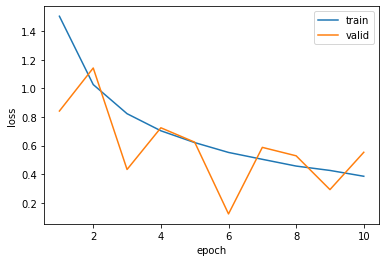

In [24]:
plt.plot(x_axis, all_losses, label='train')
plt.plot(x_axis, valid_losses_list, label='valid')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend();

In [0]:
correct, total=0, 0
predictions=[]


In [0]:
model.eval();
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, labels= data[0].to(device), data[1].to(device)
        #inputs= inputs.view(-1, 32*32*3)
        outputs= model(inputs)
        #the class with the highest score
        _, predicted= torch.max(outputs.data, 1)
        predictions.append(outputs)
        total+= labels.size(0)
        correct+= (predicted==labels).sum().item()

In [27]:
print(f' Accuracy score of: {correct/total}')


 Accuracy score of: 0.8205


On the testing data, the model is correct 82% of the time. This is really impressive of our model having built it from scratch. 




### Conclusion
After having reimplemented the AlexNet paper, I am glad it gets a great perfomance at classifying images on CIFAR10 datset. At the time of writing, the best model gets 96.53%, [as seen here](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130), which has a better architecture and tricks to improve model perfomance.

Please reach out to me if you spot something I might have missed as I am also still learning.